# Run simple FACET-II Linac simulation

# Set up environment variables and import functions

In [1]:
from pytao import Tao
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
import math
from os import path,environ
import os
import pandas as pd

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles
import subprocess

from IPython.display import display


# Set environment variable - needed for lattice_init
#%env FACET2_LATTICE /Users/cemma/Downloads/facet2-lattice
%env FACET2_LATTICE /sdf/home/s/sanjeev/github/facet2-lattice

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 
# Note that you can't put a comment at the end of the magic line, jupyter doesn't read it as a comment

# Load helper functions
#%run /Users/cemma/Documents/Work/FACET-II/Bmad_sims/BmadHelperFunctions.ipynb
%run /sdf/home/s/sanjeev/github/bmad/l1_l2_phase_scan/BmadHelperFunctions.ipynb

env: FACET2_LATTICE=/sdf/home/s/sanjeev/github/facet2-lattice
Make sure enviornment was set!:   /sdf/home/s/sanjeev/github/facet2-lattice


# Start Tao, set Linac Phases and plot Twiss Functions

In [2]:
tao=Tao('-init {:s}/bmad/models/f2_elec/taoCEedit.init -noplot'.format(environ['FACET2_LATTICE'])) 

In [3]:
# Load floorplan and plot Twiss
elements=tao.lat_ele_list();
#tao.lat_list(elements[0],'ElementType')
tao.ele_gen_attribs(elements[0]);

floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep="[\s\n]+",engine='python',
            names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)
floorplan[::25].head(7);

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/lscratch/sanjeev/tmp/ipykernel_2110838/3273526228.py:6: SyntaxWarning: invalid escape sequence '\s'
  floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep="[\s\n]+",engine='python',


In [4]:
# Display all the rf cavity elements
floorplan[floorplan.ElementType.str.contains('cavity')][::1].head(10);
# Display all Bunch Compressor elements
floorplan[floorplan.ElementName.str.contains('BC')][::1].head(670);

In [5]:
# Find element strings matching L1, L2 and L3
#These more general match strings might cause problems by including both lords and slaves!
L1MatchStrings = ["K11_1*", "K11_2*"]
L2MatchStrings = ["K11_4*", "K11_5*", "K11_6*", "K11_7*", "K11_8*", "K12_*", "K13_*", "K14_*"]
L3MatchStrings = ["K15_*", "K16_*", "K17_*", "K18_*", "K19_*"]

#Therefore, use lat_list and these general search strings to get specific elements
#Recall that, by default, lat_list has the flag "-track_only" so lords are not included
#But some of the tracking elements are super_slaves which cannot be `set`

#"-array_out" flag is on by default but if flags are edited, need to re-add manually to get numeric values back

L1MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L1MatchStrings ] )
L2MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L2MatchStrings ] )
L3MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L3MatchStrings ] )

# Define energy setpoints at exit of L0 L1 L2 in eV
L0energy = 0.125e9;    
L1energy = 0.338e9;
L2energy = 4.5e9;






def sim(L1phase, L2phase, n, dir_name):
    
    # Phase L1
    setLinacPhase(L1MatchStrings, L1phase)
    setLinacGradientAuto( L1MatchStrings, L1energy - L0energy )
    
    # Phase L2
    setLinacPhase(L2MatchStrings, L2phase)
    setLinacGradientAuto( L2MatchStrings, L2energy - L1energy )

    display('L1phase and L2phase set')
    #Get twiss functions
    tao.cmd('set global lattice_calc_on = T')
    s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
    x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
    beta_x=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
    beta_y=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
    alpha_x=np.array([tao.lat_list(x,'ele.a.alpha')[0] for x in floorplan.Index])
    alpha_y=np.array([tao.lat_list(x,'ele.b.alpha')[0] for x in floorplan.Index])
    etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
    eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
    eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])
    
    display('twiss parameters set')
    #fig.savefig(savefolder+'beamline'+savestem,transparent=False,bbox_inches='tight')


    # Set the number of macro-particles
    tao.cmd('set beam_init n_particle = 1000'); # limit to 10k particles for now 
    #todo - increase beam size to 1e5
    
    # Change the staring input beam to a S2E beam obtained from IMPACT 
    # tao.cmd('set beam_init position_file=L0AFEND_matched.h5')# IF you want to change the beam to the new matched beam at the start
    # tao.cmd('reinit beam')
    
    # Change the starting beam to a matched Gaussian distribution with known charge and sigz
    tao.cmd('set beam_init sig_z=0.78e-3')
    tao.cmd('set beam_init bunch_charge=2e-9')
    tao.cmd('reinit beam')

    dispaly('beam setup')
    # Activate CSR and run particle tracking
    
    tao.cmd('call Activate_CSR[44].tao');
    #tao.cmd('csron') #only works once we define the alias "csroff" in the next section.
    tao.cmd('csroff') #only works once we define the alias "csroff" in the next section.
    tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
    tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    display('exporting beam')
    #save data to be plot later
    P = ParticleGroup(data=tao.bunch_data('PENT'))
    P.write(f'./export/{dir_name}/openpmd_particles{n}.h5')

    #display done
    display(f'Run {n} finished')
    display(f'now creating plot {n}')

    P = P[P.status==1]
    P.drift_to_z()
    # General lPS plot and transverse profile
    P.plot('delta_t', 'energy',bins=300)
    
    plt.suptitle(f'L1phase = {L1phase} and L2phase = {L2phase}')
    plt.subplots_adjust(top=0.9)

    plt.savefig(f'./export/{dir_name}/plots/plot_{n}.png')

    display(f'Plot {n} created')

    
    
    
    return tao




# Scan L1phase and L2phase

In [6]:


import os
from datetime import datetime

# Get the current date and time
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define the directory name
dir_name = f"data_{current_time}"
display(f'making dir: {dir_name}')

# Create the directory
os.makedirs(f'./export/{dir_name}', exist_ok=True)
os.makedirs(f'./export/{dir_name}/plots', exist_ok=True)



# Define L1 and L2 phases in deg
# Define the ranges for L1phase and L2phase
#L1phase_range = range(-15, -21, -1)
#L2phase_range = range(-35, -46, -1)
L1phase_range = range(-14, -15, -1)
L2phase_range = range(-34, -35, -1)

display(L1phase_range)

# Create a DataFrame to display the lists
data = {
    'L1phase_range': L1phase_range,
    'L2phase_range': L2phase_range
}

df = pd.DataFrame(data)
df




'making dir: data_2024-05-25_10-52-50'

range(-14, -15, -1)

,L1phase_range,L2phase_range
0,-14,-34


'Running L1phase: -17'

'Running L2phase: -41.5'

'Run 1 finished'

'now creating plot 1'

'Plot 1 created'

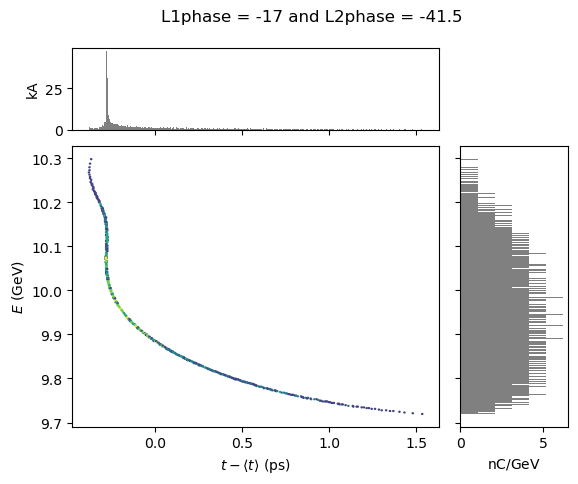

In [7]:
n = 1

# Define L1 and L2 phases in deg for testing
L1phase2 = -17; 
L2phase2 = -41.5;



# Loop over the ranges
for L1phase in L1phase_range:
    display(f'Running L1phase: {L1phase2}')
    for L2phase in L2phase_range:
        display(f'Running L2phase: {L2phase2}')
        try:
            sim(L1phase2, L2phase2, n, dir_name)
        except Exception as e:
            display(f"Error during simulation {n} with L1phase={L1phase2} and L2phase={L2phase2}: {e}")
        n += 1

#P = ParticleGroup(data=tao.bunch_data(PENT))

#P.write('/export/openpmd_particles.h5')




# Plot results

# Plot LPS at different locations
# now look only at PENT
locations = ['PENT'];

for location in locations:
    P = ParticleGroup(data=tao.bunch_data(location))
    # Select out live particles
    P = P[P.status==1]
    P.drift_to_z()
    # General lPS plot and transverse profile
    P.plot('delta_t', 'energy',bins=300)

# Plot the transverse spot at IP
P = ParticleGroup(data=tao.bunch_data('PENT'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()
# General lPS plot and transverse profile
P.plot('x', 'y',bins=300)
stats = tao.bunch_params('PENT')
print(stats['sigma_t'])
print(P.twiss('x'))
print(P.twiss('y'))

# Plot the slice emittance and current profile
P = ParticleGroup(data=tao.bunch_data('PENT'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()
# Define minz and maxz
mint = 1.1e-12+3.31822e-6
maxt = 2.2e-12+3.31822e-6

# Filter P.x for values between minx and maxx
filtered_indices = np.where((P.t >= mint) & (P.t <= maxt))
filtered_P_x = P.t[filtered_indices]
filtered_P_y = P.pz[filtered_indices]
filtered_charge = P.weight[filtered_indices]

# 2d Hist filtered data
plt.hist2d(filtered_P_x, filtered_P_y, weights = filtered_charge,bins=100, cmap='viridis')
plt.colorbar(label='Weighted Count')
plt.xlabel('P.x')
plt.ylabel('P.y')
plt.title(f'2D Histogram of P.x and P.y (weighted) between {mint} and {maxt}')
plt.grid(True)
plt.show()

P = P[filtered_indices]
P.plot('delta_t', 'energy',bins=300)

gamma = P.energy/0.511e6;
z = (P.t-np.mean(P.t))*3e8;
nslices = 200;
plt.scatter(z,gamma)
plt.show()
emitx, emity, slicez, slicebunchingfactor, current = calculate_slice_emittance(P.x, P.xp, P.y, P.yp, z, gamma, nslices, -1.0*P.charge)